In [1]:
%matplotlib inline
%autosave 60

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import copy
import scipy.optimize
import time
import pickle as pkl
import sys
sys.path.append('../boresightUtils/')

from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic
from boresightUtils import *

Autosaving every 60 seconds


In [3]:
# Instrument Specs
focalLengths = [135, 375, 750]
whDegs = [(7.91, 5.93), (2.85, 2.13), (1.42, 1.07)] # Image width and height in Degrees
plateScales = [8.64, 3.11, 1.44] # plate scales of cameras in arcsec / px
whPxs = [convert_fov_degs_px(whDeg, plateScale) for whDeg, plateScale in zip(whDegs, plateScales)] 

# Notebook Configurables
camNum = 0 # Choose an instrument
slewRate = 6 # degs / s
driftDir = np.array([[1],[0]]) # Drifting right in px space initially
driftSpeedArcSec = 13 # arcseconds / s
threshold = 0.3 # Bright pixel Threshold
gaussianBlurSigma = 1 # PSF width
pointingSigma = 300 # STD of pointings around image center
expTime = 15 # seconds
seed = 1000 # 98735927 # Set a seed (optional)
figsDir = os.path.expanduser('~/software/sitcom/starTracker/findBoresight/notebooks/plots/') # Where to save the figures
saveFig = True
dr = 1 # Radial bin width for Scoring Center
nStars = 35

# Parameters Derived / Selected from Configurables
driftSpeedDeg = driftSpeedArcSec / 3600 # deg / s 
focalLength = focalLengths[camNum]
plateScale = plateScales[camNum]
width, height = whPxs[camNum]
driftVel = driftSpeedArcSec / (plateScale) * driftDir # Drift in px / s
xMu = width / 2 
yMu = height / 2

# numpy random Stuff
if seed is None:
    rng = np.random.default_rng() # Make one of these things
else:
    rng = np.random.default_rng(seed)

# Dictionary of Configurables to pass to functions
configDict = {
    'expTime': expTime,
    'slewRate': slewRate,
    'driftVel': driftVel,
    'threshold': threshold,
    'rng': rng,
    'imageWidth': width,
    'imageHeight': height,
    'gaussianBlurSigma': gaussianBlurSigma,
    'xMu': xMu,
    'yMu': yMu,
    'pointingSigma': pointingSigma,
    'nStars': nStars
}

In [9]:
# for i in range(nImages):
configDict['gaussianBlurSigma'] = 1
arcImg, pointingCenter = make_arc_image(configDict, thetaInit=0, driftTime=0)
blurredImg = gaussian_blur_image(arcImg, configDict)
brightPxs = make_threshold_image(arcImg, configDict)

In [10]:
print(blurredImg[blurredImg>0.3], len(blurredImg[blurredImg>0.3]))

[0.4841789  0.77310023 0.94717553 ... 0.65502729 0.6544635  0.47139938] 95562


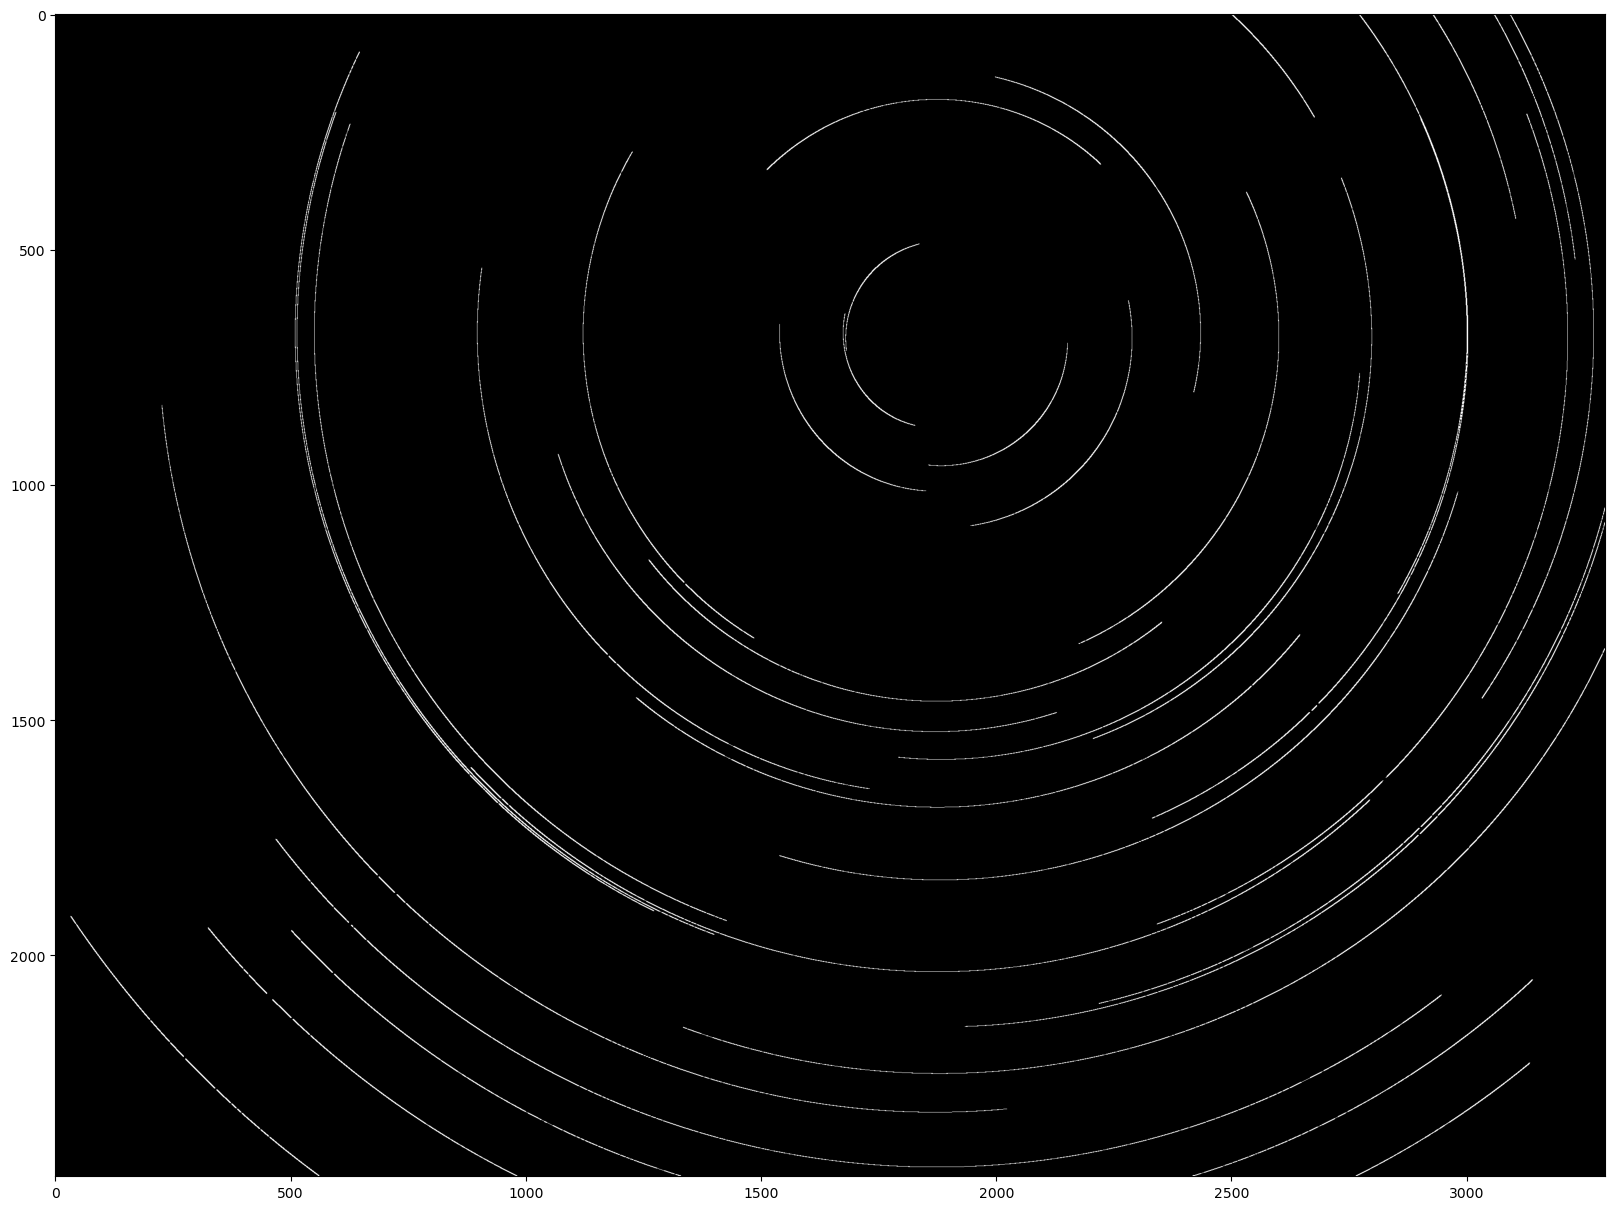

In [13]:
# figName = f'drift{driftSpeedArcSec}_arc_image.png'
# show_arc_image(arcImg, saveFig=saveFig, figsDir=figsDir, figName=figName)
figNameThresholded = f'drift{driftSpeedArcSec}_thresholded_arc_image101.png'
plot_arc_image(brightPxs, saveFig=saveFig, figsDir=figsDir, figName=figNameThresholded)

In [15]:
# drifts = np.arange(0, 16, 5)
drifts = [13]
nTrials = 15
optErrors = np.zeros((nTrials, len(drifts), 2))
threshold = configDict['threshold']
dv = np.array([1, 0]).reshape(2, 1)
configDict['gaussianBlurSigma'] = 2

for iDrift, drift in enumerate(drifts):
    for iTrial in range(nTrials):
        driftVel = drift / (plateScale) * dv # Drift in px / s
        configDict['driftVel'] = driftVel
        arcImg, pointingCenter = make_arc_image(configDict)
        pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
        brightPxs = make_threshold_image(arcImg, configDict)
        arguments = (brightPxs, dr)
    
        deRes = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                      args=arguments)
        optimizerError = -(pcIdx - deRes.x)
        optErrors[iTrial, iDrift] = optimizerError

[[ 535.96630063  -11.48498803  -11.38018561   -8.95591115 -286.94022512
    -6.8334312   -12.42708555  -11.06754885  -10.98537629  -11.04350607
    -7.23679999  -13.75594906  -10.55226661   -4.15991705   -8.2390214 ]
 [-522.78011551   -8.56022304  -10.86683969  -12.45842698  586.84654756
   -11.44669513  -10.83828055  -11.61455024   -8.59715175   -8.64315995
   -14.10674921   -6.26154235   -2.93754722  -10.00560377  -11.90115037]]


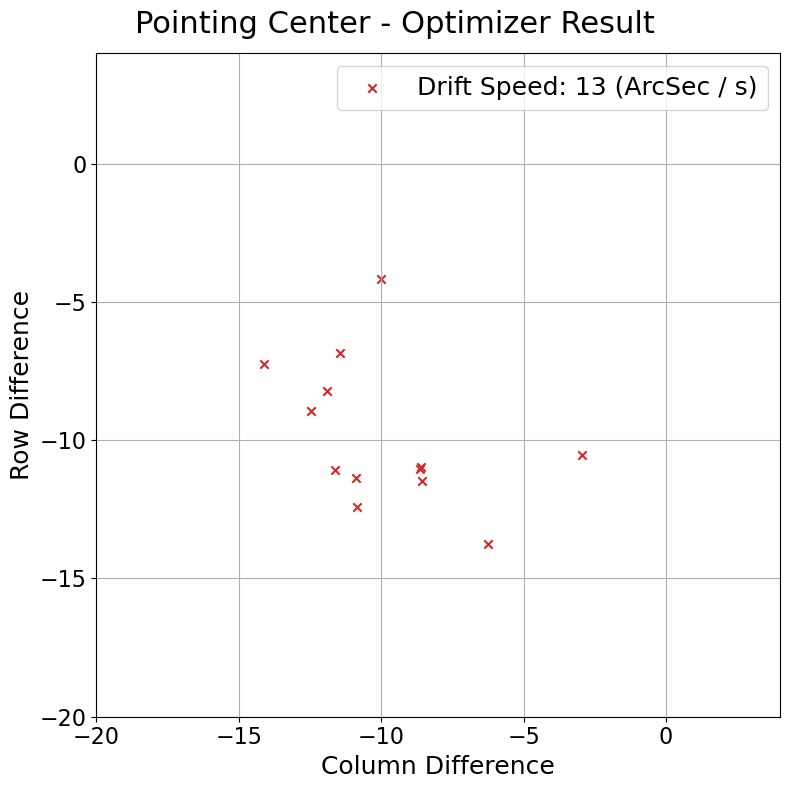

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle('Pointing Center - Optimizer Result', fontsize=22)
ax.set_ylabel('Row Difference', fontsize=18)
ax.set_xlabel('Column Difference', fontsize=18)
# ax.set_xlim(-1, 14)
# ax.set_ylim(-1, 14)
ax.tick_params(labelsize=16)
ax.grid(visible=True)

colors = ['tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:blue', 'tab:purple']

for iDrift, drift in enumerate(drifts):
    optErrorData = optErrors[:, iDrift].transpose()
    print(optErrorData)
    x = optErrorData[1]
    y = optErrorData[0]
    ax.scatter(x, y, marker='x', label=f'Drift Speed: {drift} (ArcSec / s)', color=colors[iDrift])
    ax.set_xlim(-20, 4)
    ax.set_ylim(-20, 4)
    
ax.legend(fontsize=18)
fig.tight_layout()
fName = 'drift_effect.png'
fileName = os.path.join(figsDir, fName)
fig.savefig(fileName)
plt.show(fig)

In [67]:
nTrials = 20
errors = np.zeros((nTrials, 2, 2))
threshold = configDict['threshold']

for iDrift, drift in enumerate([0, 15]):
    for iTrial in range(nTrials):
        driftVel = drift / (plateScale) * driftDir # Drift in px / s
        configDict['driftVel'] = driftVel
        arcImg = make_arc_image(configDict)
        pointingCenter = configDict['pointingCenter']  
        pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
        brightPxs = make_threshold_image(arcImg, configDict)
        arguments = (brightPxs, dr)
        deRes = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                      args=arguments)
        optimizerError = pcIdx - deRes.x
        errors[iTrial, iDrift] = optimizerError

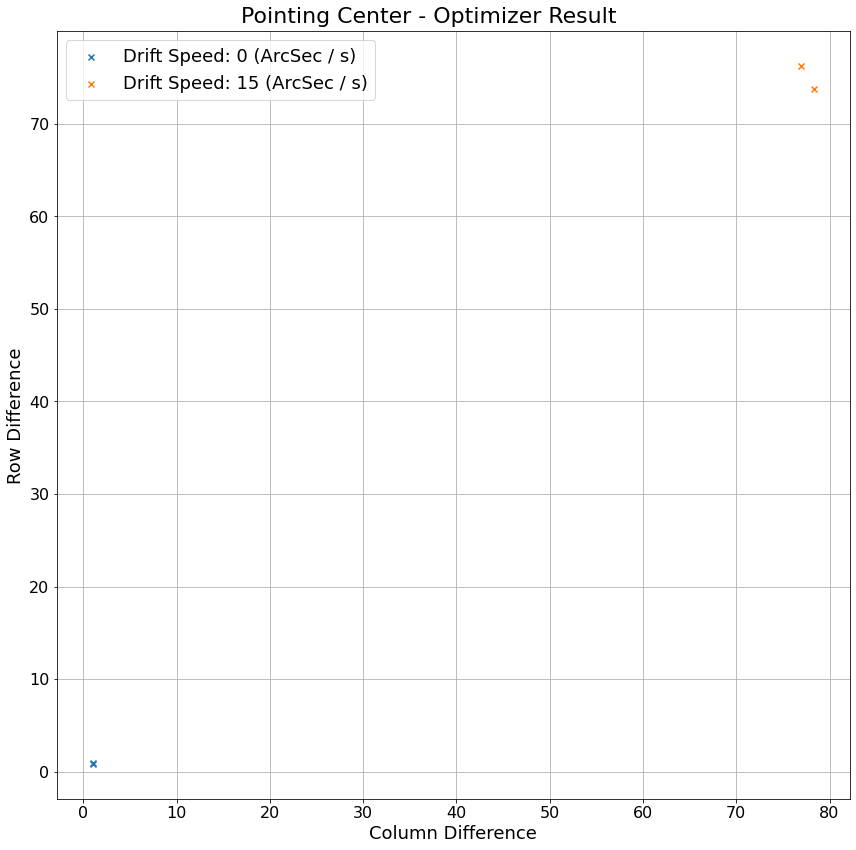

In [71]:
fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Pointing Center - Optimizer Result', fontsize=22)
ax.set_ylabel('Row Difference', fontsize=18)
ax.set_xlabel('Column Difference', fontsize=18)
# ax.set_xlim(-1, 14)
# ax.set_ylim(-1, 14)
ax.tick_params(labelsize=16)
ax.grid(visible=True)

for iDrift, drift in enumerate([0, 15]):
    data = errors[:, iDrift]
    x = data[1]
    y = data[0]
    ax.scatter(x, y, marker='x', label=f'Drift Speed: {drift} (ArcSec / s)')
    
ax.legend(fontsize=18)
fig.tight_layout()
fName = 'drift_effect.png'
fileName = os.path.join(figsDir, fName)
# fig.savefig(fileName)
plt.show(fig)

In [42]:
radScores = np.zeros(brightPxs.shape)
pcIdx = xy_image_coord_transform(pointingCenter, arcImg)
rowMin, rowMax = (int(pcIdx[0]-50), int(pcIdx[0]+50))
colMin, colMax = (int(pcIdx[1]-50), int(pcIdx[1]+50))

for irow in range(rowMin, rowMax):
    for icol in range(colMin, colMax):
        c = np.array([irow, icol])
        radScores[irow, icol] = score_center(c, brightPxs, dr)

radScores = radScores[rowMin:rowMax, colMin:colMax]

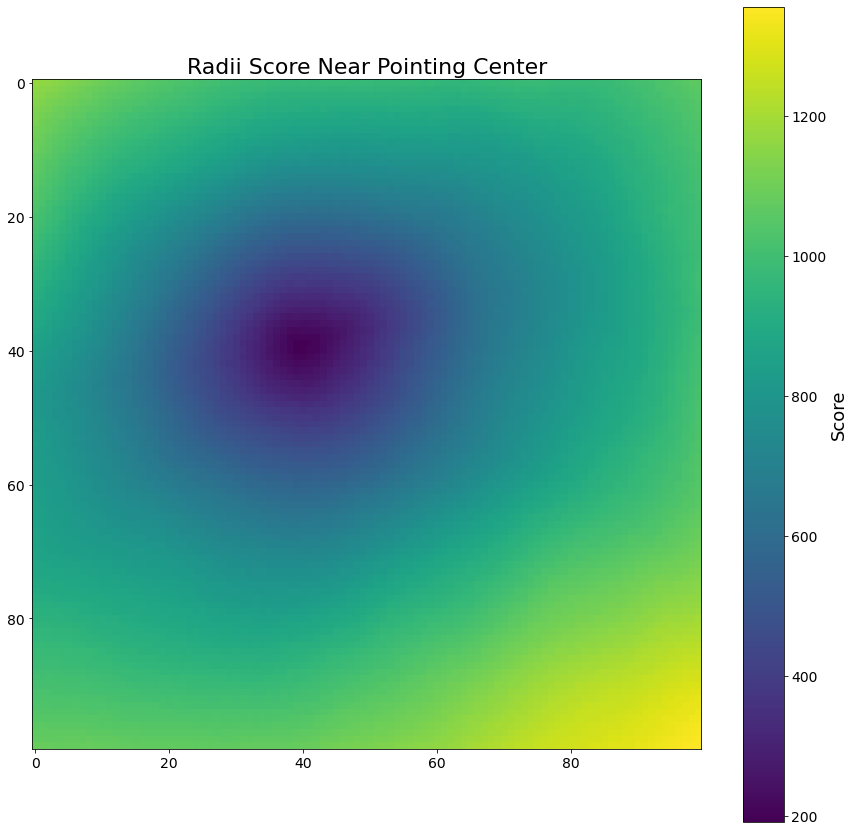

In [43]:
figName = f'drift{driftSpeedArcSec}_radii_center_scores.png'
plot_scores(radScores, 'Radii', saveFig=saveFig, 
            figsDir=figsDir, figName=figName)

In [20]:
hyperparams = [(0.01, 3), (0.01, 1), (0.002, 3), (0.002, 1)]
nTrials = 20
arcImg = make_arc_image(configDict)
arcImgCp = gaussian_filter(arcImg, sigma=gaussianBlurSigma)
brightPxs = np.zeros(arcImg.shape)
brightPxs[arcImgCp > threshold] = 1

optimizerResults = np.zeros((len(hyperparams), nTrials, 2))

for iHyper, (tol, dr) in enumerate(hyperparams):
    arguments = (brightPxs, dr)
    
    for iTrial in range(nTrials):
        deRes = scipy.optimize.differential_evolution(score_center, ((0, height), (0, width)), 
                                                      args=arguments, tol=tol)
        optimizerResults[iHyper, iTrial] = deRes.x

KeyboardInterrupt: 

In [ ]:
pklFileName = 'optimizerErrors.pkl'
with open(pklFileName, 'wb') as f:
    pkl.dump(optimizerErrors, f)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14),)
fig.suptitle('Pointing Center - Score Minima', fontsize=22)

for optErr, ax, (tol, dr) in zip(optimizerErrors, axs.ravel(), hyperparams):
    row = optErr[:, 0]
    col = optErr[:, 1]
    print(optErr.std(axis=0, ddof=1))
    ax.scatter(col, row)
    ax.set_title(f'tol={tol}, dr={dr}', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.set_ylabel('Row', fontsize=18)
    ax.set_xlabel('Column', fontsize=18)
    ax.set_ylim(-.8, 0)
    ax.set_xlim(-.8, 0)

plt.show()